## Computer Vision Assignment 1 ( Image Stitching )
#### Theodoros Antoniou i6266659

In [1]:
import numpy as np
import cv2 as cv
from math import sqrt, pow
import matplotlib.pyplot as plt
import random
from skimage.transform import AffineTransform
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
import warnings

from scipy.spatial import distance
warnings.filterwarnings('ignore')


## Loading Images and declaring Functions

In [2]:
'''Select the Images to be used and enter them to the sample_images Folder'''
#load images that we want to stitch
def load_img(LEFT_PATH,RIGHT_PATH):
    left_img = cv.imread(LEFT_PATH)
    left_img = cv.cvtColor(left_img,cv.COLOR_BGR2RGB)
    right_img = cv.imread(RIGHT_PATH)
    right_img = cv.cvtColor(right_img,cv.COLOR_BGR2RGB)

    return left_img, right_img

def display_img(img):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img)

## Corner Harris Keypoints

In [3]:
def Corner_Harris(img, blocksize, ksize, K, threshold):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv.cornerHarris(gray, blockSize=blocksize, ksize=ksize, k=K)

    #Turn red all the points of interest from Harris Corner
    img[dst>threshold*dst.max()] = [255,0,0]

    display_img(img)
    plt.title("Corner Harris Selection")

    return dst


def Convert_To_Keypoints(points, trs):

    '''Coverting from Points to Memorry Keypoints'''
    kps = np.argwhere(points > trs * points.max())
    kps = [cv.KeyPoint(float(pt[1]), float(pt[0]), 13) for pt in kps]


    return kps

## Caclulating Distances and Selecting Best Matches

In [4]:
def distances(des1, des2, method='euclidean'):

    '''Using Euclidian/Correlation by first normalizing the descriptors values for Euclidian and then Using
    cdist from scipy'''

    if method == 'euclidean':
        norm_des1 = np.linalg.norm(des1, ord=2, axis=1).reshape(-1,1)
        norm_des2 = np.linalg.norm(des2, ord=2, axis=1).reshape(-1,1)
        #Return Normalize distance
        return cdist(des1/norm_des1, des2/norm_des2, 'euclidean')
    else:
        return cdist(des1, des2, 'correlation')

def best_matches(distance,matches):

    '''Selecting and Detecting the best_matches. I picked a starting Threshold of the min + std and then start decreasing
     until the dropout of maximum matches is reached.'''
    ts = distance.min() + distance.std()
    condition = True
    while condition == True:

        best_matches = np.where(distance < ts)

        listOfCoordinates= list(zip(best_matches[0], best_matches[1]))
        '''Here we filter the list of coordinates to get only the best unique pairs'''
        flag = 1
        match_cord = []
        for cord in listOfCoordinates:
            for i in range(len(match_cord)):
                if (cord[0] != match_cord[i][0] and cord[1] != match_cord[i][1] ):
                    flag = 1
                else:
                    flag = 0

            if flag == 1:
                match_cord.append(cord)
        ts = ts - 0.01
        condition = len(match_cord) > matches

    return match_cord

## Ransac Implementation

In [5]:
def gen_random_match(matches):

    '''Genarting A Unique Triple, in order to initiate Ransac Algorithm'''
    matches_int= np.random.randint(len(matches),size=3)
    while len(matches_int) != len(np.unique(matches_int)):
            matches_int = np.random.randint(len(matches), size=3)

    return matches_int

def inliner_residuals(inliers, match_left, match_right,affine_TF):

    '''Calculating the MSE of the Inliners in order to use as Score.'''

    match_left_arr = np.asarray(match_left)
    match_right_arr = np.asarray((match_right))
    z = np.ones((len(match_left_arr),1))
    match_left_arr = np.append(match_left_arr,z,axis=1)

    MSE = 0
    for pixels in inliers:
        wrapped_p1 = np.matmul(match_left_arr[pixels], np.transpose(affine_TF[:2]))[0]
        wrapped_p2 = np.matmul(match_left_arr[pixels], np.transpose(affine_TF[:2]))[1]

        error = pow(match_right_arr[pixels][0] - wrapped_p1,2) + pow(match_right_arr[pixels][1] - wrapped_p2,2)
        MSE = MSE + error
    MSE = sqrt(MSE) / (2 * len(inliers))
    return MSE

def fit_line(X,x_target,y_target):

    '''Performing bivariate Linear Regresion by fitting one line for the X_target and one line for y_target'''
    X = np.array(X)
    x_target = np.asarray(x_target).reshape(-1,1)
    y_target = np.asarray(y_target).reshape(-1,1)

    #Fit first line
    reg1 = LinearRegression().fit(X, x_target)
    a1, b1, c1 = reg1.coef_[0][0], reg1.coef_[0][1], reg1.intercept_[0]


    #Fit second Line
    reg2 = LinearRegression().fit(X, y_target)
    a2, b2, c2 = reg2.coef_[0][0], reg2.coef_[0][1], reg2.intercept_[0]


    return a1,b1,c1,a2,b2,c2


def Ransac (L_pixels,R_pixels, tolerance, ts, max_iter=1000):

    '''Ransac, here we generate a random selection of 3 matches, and then we perform Linear
    Regression to predict the pixels of the right image'''
    condition = True
    iter = 0
    while condition == True:
        random_matches = gen_random_match(L_pixels)

        X = []
        x_target = []
        y_target = []
        for pixel in random_matches:
            X.append(L_pixels[pixel]) # Appending the Left pixels
            x_target.append(R_pixels[pixel][0]) # appending the first pixel of right image
            y_target.append(R_pixels[pixel][1]) # appending second pixel of right image

        a1,b1,c1,a2,b2,c2 = fit_line(X,x_target,y_target) ##Fitting the 2 lines and getting back the Coefs

        inliers = []
        outliers = []
        for pixel in range(len(L_pixels)):
            if pixel not in random_matches:
                x_pi = L_pixels[pixel][0]
                y_pi = L_pixels[pixel][1]
                x_pi_target = R_pixels[pixel][0]
                y_pi_target = R_pixels[pixel][1]

                dist1 = abs(x_pi_target - a1*x_pi - b1*y_pi - c1) ##Calculating the absolute distance of True - predicted from line 1
                dist2 = abs(y_pi_target - a2*x_pi - b2*y_pi - c2) ##//
                if dist1 <= tolerance and dist2 <= tolerance: ## If it is inside the margin is an inliner
                    inliers.append(pixel)
                else:
                    outliers.append(pixel)
        iter = iter + 1
        #print(iter)
        condition = len(inliers)/len(L_pixels) <= ts and iter <= max_iter

    '''Now we need to fit regression only in the inliers to get the best transformation'''
    X = []
    x_target = []
    y_target = []
    print(f'Number of Inliers: {len(inliers)}')
    print(f'Number of Outliers: {len(outliers)}')
    for pixel in inliers:
        X.append(L_pixels[pixel])
        x_target.append(R_pixels[pixel][0])
        y_target.append(R_pixels[pixel][1])

    a1,b1,c1,a2,b2,c2 = fit_line(X,x_target,y_target)

    return a1,b1,c1,a2,b2,c2,inliers

## Declaration of a master function that includes the whole pipeline

#### As parameters (blocksize, ksize, K, n_matches, threshold,d_method,margin,ts)



In [6]:
def Stitch_Images(LEFT_PATH,RIGHT_PATH,blocksize,ksize,K,n_matches,threshold, d_method,margin,ts):

    '''Pipeline'''

    '''CORNER HARRIS'''

    #Load images
    left_img, right_img = load_img(LEFT_PATH,RIGHT_PATH)
    #Sent the left image to get back the corner points
    left_harris = Corner_Harris(left_img,blocksize, ksize, K,threshold)
    #sent right image
    right_harris = Corner_Harris(right_img,blocksize, ksize, K,threshold)

    # Convert and trehshold the keypoints from harris to use later for sift
    keypoints_left = Convert_To_Keypoints(left_harris,threshold)
    keypoints_right = Convert_To_Keypoints(right_harris,threshold)

    '''Sift Descriptors'''
    sift = cv.SIFT_create()

    keypoints_left, ds_left = sift.compute(left_img, keypoints_left)
    keypoints_right, ds_right = sift.compute(right_img, keypoints_right)

    '''Calculating Euclidian/Corellation distance of the Descriptors'''

    distance = distances(ds_left, ds_right, method=d_method)

    print("Mean of the distance: ", distance.mean())
    print("Minimum distance", distance.min())
    print ("Standard Deviation", distance.std())

    # Collect the best matches and after display the number and the threshold used
    match_cord = best_matches(distance,n_matches)


    print("Number of best matches selected:",len(match_cord))

    # We take the filtered coordinates and we convert it with Dmatch to memory list
    match_cord_D = []
    for i in range(len(match_cord)):
        match_cord_D.append( cv.DMatch(match_cord[i][0], match_cord[i][1], distance[match_cord[i][0]][match_cord[i][1]]))

    # We draw the best matches
    sift_matches = cv.drawMatches(left_img,keypoints_left,right_img,keypoints_right,match_cord_D,None, flags=2)

    # Picture drawn with the best selected Matches
    display_img(sift_matches)
    plt.title("Best Selection of Matches")

    '''###Ransac###'''

    # Here we go from memory to pixels so we can then proceed with Ransac
    match_left = []
    match_right= []
    for kp in match_cord:
        left_cord  = keypoints_left[kp[0]].pt
        right_cord = keypoints_right[kp[1]].pt
        match_left.append((left_cord))
        match_right.append((right_cord))

    '''###Image Stitching and Affine Transformation###'''
    left_img, right_img = load_img(LEFT_PATH,RIGHT_PATH)
    a1, b1, c1, a2, b2, c2, inliers= Ransac(match_left, match_right, tolerance=margin, ts=ts)

    '''Cause we calculated the affine from left to right, we use the Inverse affine matrix to warp our right image
    '''
    #Build our affine Matrix
    affine_TF = np.array([[a1, b1, c1], [a2, b2, c2], [0.0, 0.0, 1.0]])
    stitched_img = cv.warpPerspective(right_img,np.linalg.inv(affine_TF),((left_img.shape[1] + right_img.shape[1]), left_img.shape[0])) #wraped image
    display_img(stitched_img)

    stitched_img[0:left_img.shape[0], 0:left_img.shape[1]] = left_img #stitched image
    display_img(stitched_img)
    plt.title("Final Stitched Image")

    in_matches = []
    for pixels in inliers:
        in_matches.append(match_cord_D[pixels])

    sift_matches_in = cv.drawMatches(left_img,keypoints_left,right_img,keypoints_right,in_matches,None, flags=2)

    display_img(sift_matches_in)
    plt.title("The inliers location of the matches")

    MSE = inliner_residuals(inliers,match_left,match_right,affine_TF)
    print('Average residual of the Inliers', MSE)


Mean of the distance:  0.6696609570974039
Minimum distance 0.06445031507018519
Standard Deviation 0.11250580384348904
Number of best matches selected: 251
Number of Inliers: 120
Number of Outliers: 128
Average residual of the Inliers 0.025175813903786117


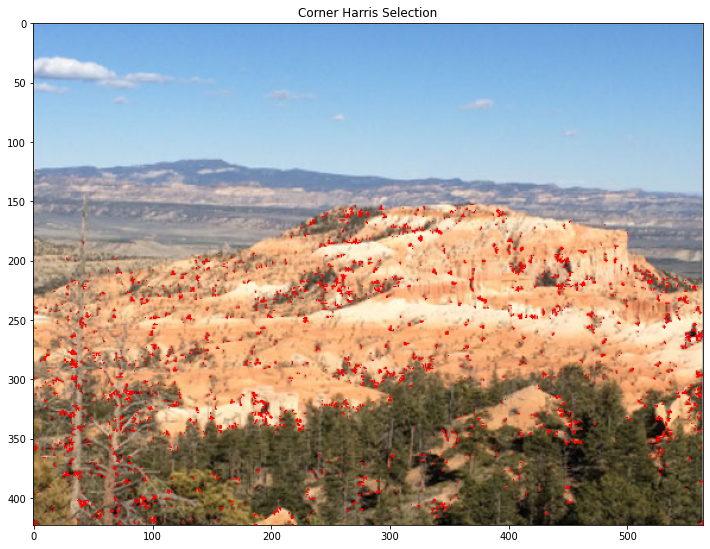

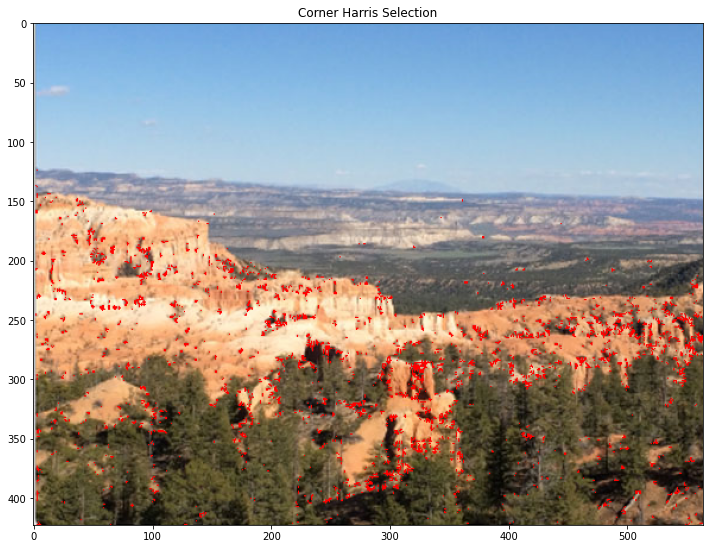

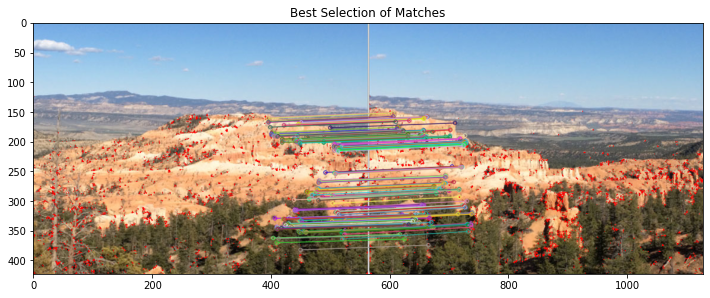

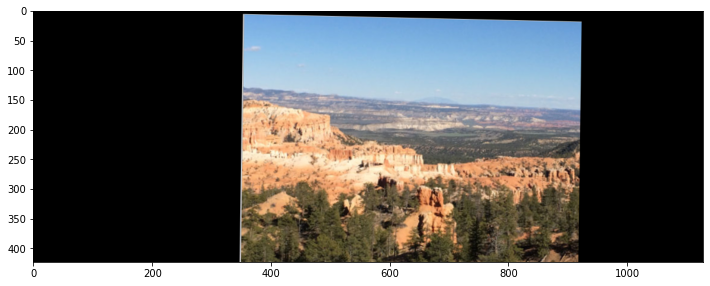

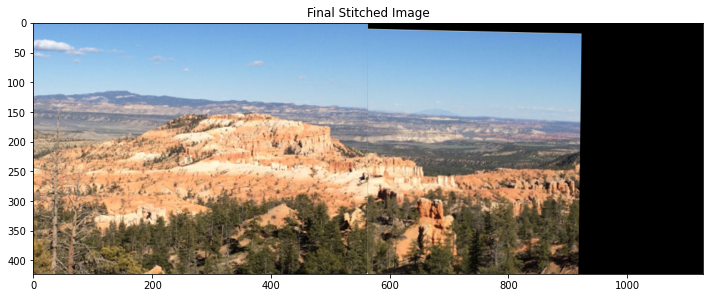

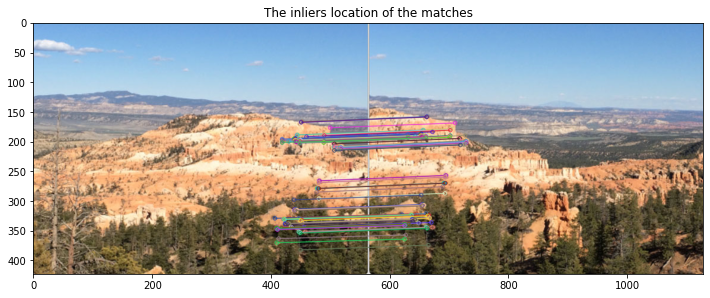

In [11]:
'''Set the parameters for the Corner Harris default values below
#blocksize = 2
#ksize = 3
#K = 0.04
threshold = 0.01
'''
'''n_matches is the number of the maximum best matches selected default value 400'''
'''d_method is the distance metric used default 'euclidian' otherwise use 'correlation' '''

''' Set the Ransac parameter
Set the parameters for Ransac default values
margin = 1 ( To be considered Inliner distange)
ts = 0.9 (Ratio of inliners/all_points )
'''

'''Define your Desired Images here from the sample_images folder'''
LEFT_PATH = '../Image_Stitching/sample_images/leftImage.png'
RIGHT_PATH = '../Image_Stitching/sample_images/rightImage.png'

Stitch_Images(LEFT_PATH,RIGHT_PATH,blocksize=2,ksize=3,K=0.04,n_matches=500,threshold=0.01,
              d_method='euclidean', margin = 1 , ts = 0.9 )

